In [1]:
import sys
import pickle
from pprint import pprint
import time
import datetime

In [2]:
from qiskit import IBMQ

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_brooklyn")
device = provider.backend.ibmq_brooklyn

In [4]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_path_graph, list_to_matrix, path_graph_state

In [5]:
vertex_list = [11, 17, 18, 19, 25,
               33, 32, 31, 39, 45,
               46, 47, 48, 49, 40,
               35, 36, 37, 26, 23,
               22, 21, 12,  8,  7,
                6,  5,  4,  3,  2,
                1,  0, 10, 13, 14,
               15, 24, 29, 28, 27,
               38, 41, 42, 43, 52,
               56, 57, 58, 59, 60,
               61, 62, 63, 64, 54,
               51, 50] # 57 qubits # simulator
max_size = len(vertex_list) # largest graph size
# vertex_list += [9,16,20,30,34,44,53,55] # add extra qubits up to 65
initial_layouts = [vertex_list[:n] for n in range(1, max_size + 1)] # initial_layouts
F_list = [3 * i + 1 for i in range(max_size // 3)] # subset of focused vertices of graph size max_size
Fs = [F_list[:(n+1) // 3] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_path_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution

In [6]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)
print("F_list:", F_list)
print("lengths of initial_layout:", [len(i) for i in initial_layouts])
pprint(initial_layouts[:10:2])

max_size: 57
shots_per_circuit: 8192
F_list: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
lengths of initial_layout: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[[11],
 [11, 17, 18],
 [11, 17, 18, 19, 25],
 [11, 17, 18, 19, 25, 33, 32],
 [11, 17, 18, 19, 25, 33, 32, 31, 39]]


In [7]:
qcs = [path_graph_state(size) for size in range(1, max_size+1)]
print(len(qcs), "qcs")

57 qcs


In [8]:
from lib_path_graphs import prepare_path_graph_qcs_list, execute_circuits

In [9]:
qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = \
    prepare_path_graph_qcs_list(qcs, 
                                adj_lists, 
                                backend,
                                optimization_level=3,
                                initial_layouts=[vertex_list[:qc.num_qubits] for qc in qcs])
print("the number of graph state circuits is: ", len(qcs_list))

/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


the number of graph state circuits is:  224


In [ ]:
jobs = execute_circuits(qcs_list,
                        backend=backend,
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=0)
print(len(jobs), "jobs")
print("job_id:", jobs[0].job_id())

In [ ]:
dt_now = datetime.datetime.now()
job_ids_filename = "job_ids_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [ ]:
with open("./pkls/" + job_ids_filename, "wb") as f:
    pickle.dump([job.job_id() for job in jobs], f)

In [ ]:
with open("./pkls/" + "properties_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

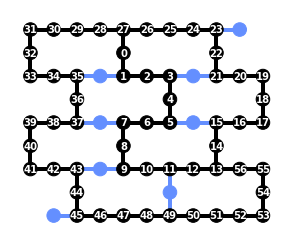

In [8]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)

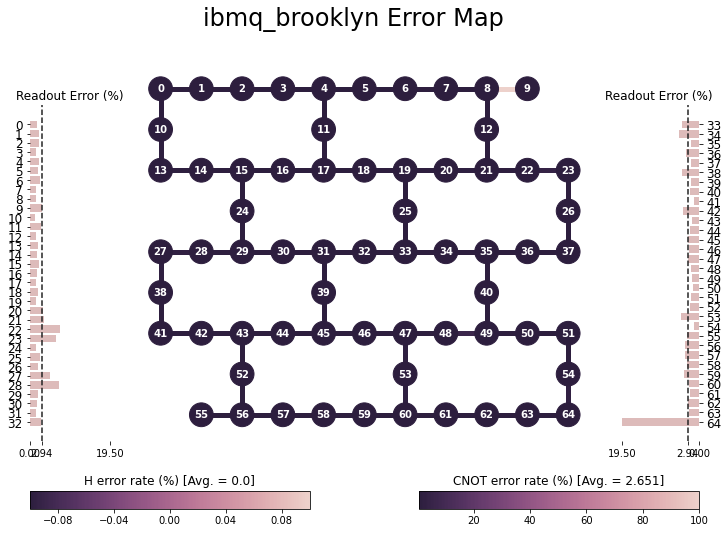

In [9]:
from qiskit.visualization import plot_error_map
plot_error_map(device)